In [1]:
import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from pyia import GaiaData
from dustmaps.planck import PlanckGNILCQuery

import scipy.interpolate as si
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter

In [2]:
gaia = at.Table.read('../data/gd1-dr3-polygon.fits')
ps1 = at.Table.read('../data/PS1-DR2_GD1-DR3_xm.fits')
joined = at.join(gaia, ps1, keys='source_id')
joined = at.unique(joined, keys='source_id')
g = GaiaData(joined)

In [3]:
c = g.get_skycoord(distance=False, radial_velocity=False)
c_gd1 = c.transform_to(gc.GD1Koposov10())

Extinction-corrected PS1 photometry

In [4]:
ebv = g.get_ebv(PlanckGNILCQuery)

Ag = 3.172 * ebv
Ar = 2.271 * ebv
Ai = 1.682 * ebv
g0 = g.gMeanPSFMag - Ag
r0 = g.rMeanPSFMag - Ar
i0 = g.iMeanPSFMag - Ai

In [5]:
len(g)

5301416

# Initializations


## Sky track

Previous sky track from: https://adrian.pw/blog/flexible-density-model-jax/

In [6]:
sky_track_data = at.Table.read('../data/dr2/dr2-sky-track.fits')
phi2_spl = si.InterpolatedUnivariateSpline(
    sky_track_data['phi1'],
    sky_track_data['phi2'], 
    k=3
)

ln_std_phi2_spl = si.InterpolatedUnivariateSpline(
    sky_track_data['phi1'],
    sky_track_data['ln_std_phi2'], 
    k=3
)

In [7]:
std = np.exp(ln_std_phi2_spl(c_gd1.phi1.degree))
sky_track_mask = np.abs(c_gd1.phi2.degree - phi2_spl(c_gd1.phi1.degree)) < 2 * std

## Distance track

Could also look at:
- RRL stars from: https://users.flatironinstitute.org/~apricewhelan/data/misc/gd1-dr2/gd1-RRL.fits
- BHB stars from: https://users.flatironinstitute.org/~apricewhelan/data/misc/gd1-dr2/gd1-BHB.fits

Distance modulus de Boer et al. 2020:
$$
\textrm{DM}(\phi_1) = 15.001 + 2.421\times10^{-2}\,\phi_1 + 2.410\times10^{-4}\phi_1^2
$$

In [8]:
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])

## Rough proper motion box

In [9]:
d_tmp = coord.Distance(distmod=distmod_spl(c_gd1.phi1.degree))
c_tmp = g.get_skycoord(distance=d_tmp, radial_velocity=0*u.km/u.s)
c_gd1_refl = gc.reflex_correct(c_tmp.transform_to(gc.GD1Koposov10()))

In [10]:
_pm1_lim = [-9, -3.5] * u.mas/u.yr
_pm2_lim = [-1.4, 1.] * u.mas/u.yr
rough_pm_mask = (
    (c_gd1_refl.pm_phi1_cosphi2 > _pm1_lim.min()) &
    (c_gd1_refl.pm_phi1_cosphi2 < _pm1_lim.max()) &
    (c_gd1_refl.pm_phi2 > _pm2_lim.min()) &
    (c_gd1_refl.pm_phi2 < _pm2_lim.max())
)

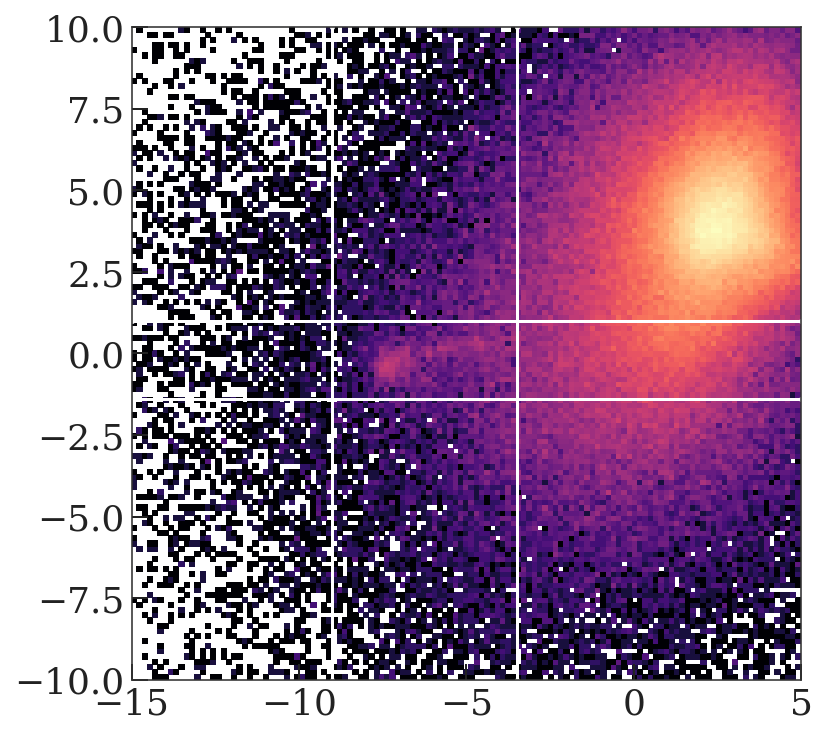

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    c_gd1_refl.pm_phi1_cosphi2.value[sky_track_mask],
    c_gd1_refl.pm_phi2.value[sky_track_mask],
    bins=(np.linspace(-15, 5, 128),
          np.linspace(-10, 10, 128)),
    norm=mpl.colors.LogNorm()
)
for xx in _pm1_lim:
    ax.axvline(xx.value, color='w')
for xx in _pm2_lim:
    ax.axhline(xx.value, color='w')

## C(A)MD

In [12]:
mask = (
    sky_track_mask &
    rough_pm_mask
)

gi0 = g0 - i0
Mr0 = r0 - d_tmp.distmod.value

H, xe, ye = np.histogram2d(
    gi0[mask],
    Mr0[mask],
    bins=(
        np.linspace(-1, 1.25, 151),
        np.linspace(-4, 7, 151)
    )
)
xc = 0.5 * (xe[:-1] + xe[1:])
yc = 0.5 * (ye[:-1] + ye[1:])

/tmp/ipykernel_506679/2788309629.py:3: RuntimeWarning: invalid value encountered in true_divide
  sub = H_smoo / H_smoo.sum(axis=0)


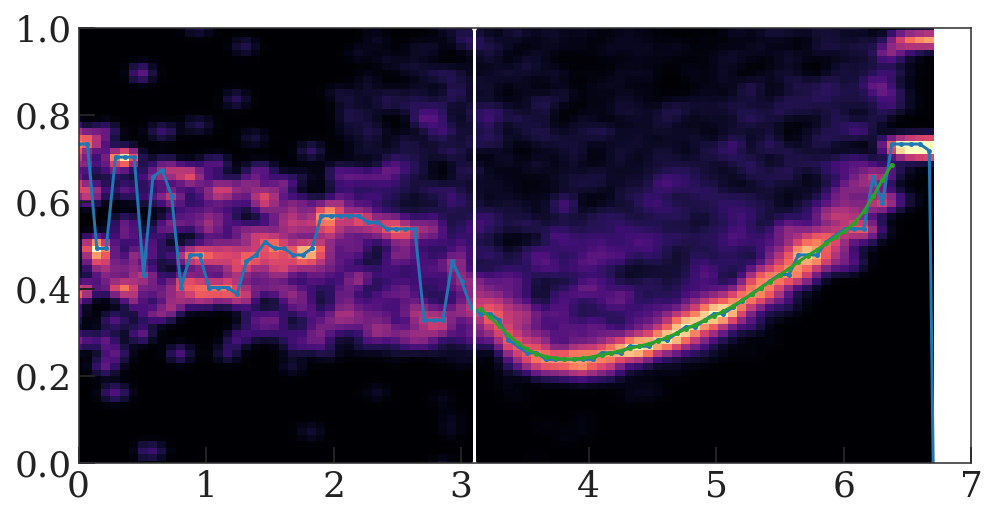

In [13]:
H /= H.max()
H_smoo = gaussian_filter(H, 1)
sub = H_smoo / H_smoo.sum(axis=0)

plt.figure(figsize=(8, 4))
plt.pcolormesh(ye, xe, sub, vmax=0.1)
plt.plot(yc, xc[sub.argmax(axis=0)], color='tab:blue')
plt.xlim(0, 7)
plt.ylim(0, 1)
plt.axvline(3.1, color='w')

ms_gi_track, ms_r_track = xc[sub.argmax(axis=0)], yc
ms_gi_track = gaussian_filter(ms_gi_track, sigma=1.5)

ms_mask = (ms_r_track > 3.1) & (ms_gi_track < 0.8) & (ms_r_track < 6.4)
ms_gi_track = ms_gi_track[ms_mask]
ms_r_track = ms_r_track[ms_mask]

plt.plot(ms_r_track, ms_gi_track, color='tab:green')

ms_r_gi_spl = si.InterpolatedUnivariateSpline(
    ms_r_track[np.argsort(ms_r_track)],
    ms_gi_track[np.argsort(ms_r_track)],
    k=3, 
    ext=1
)

(-0.25, 0.25)

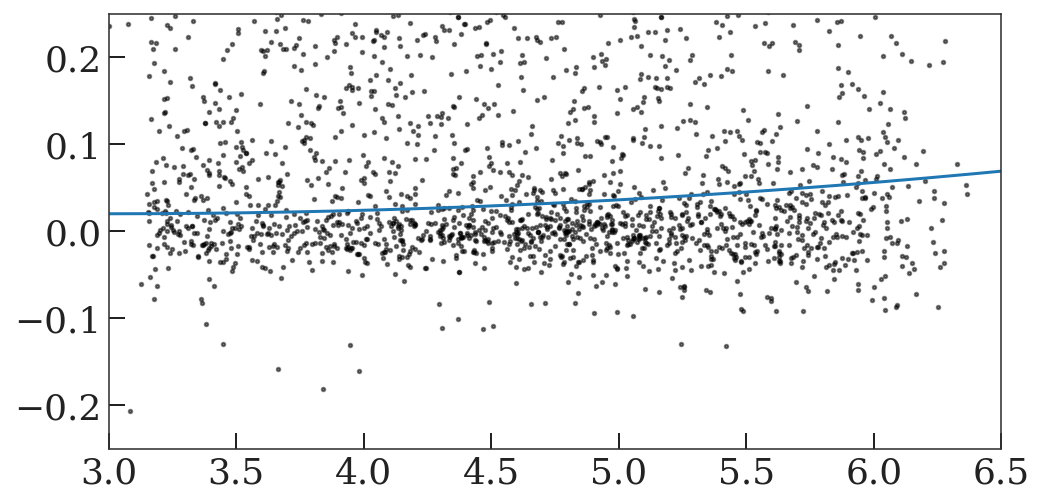

In [14]:
tmp_mask = np.abs((gi0 - ms_r_gi_spl(Mr0))) < 0.1

plt.figure(figsize=(8, 4))
plt.scatter(
    Mr0[mask], 
    (gi0 - ms_r_gi_spl(Mr0))[mask],
    s=3,
    alpha=0.5
)

_grid = np.linspace(3, 6.5, 256)
cmd_width_spl = np.poly1d([4e-3, 0, 0.02])
plt.plot(_grid, cmd_width_spl(_grid - 3), marker='', color='tab:blue')

plt.xlim(3, 6.5)
plt.ylim(-0.25, 0.25)

(7.0, -4.0)

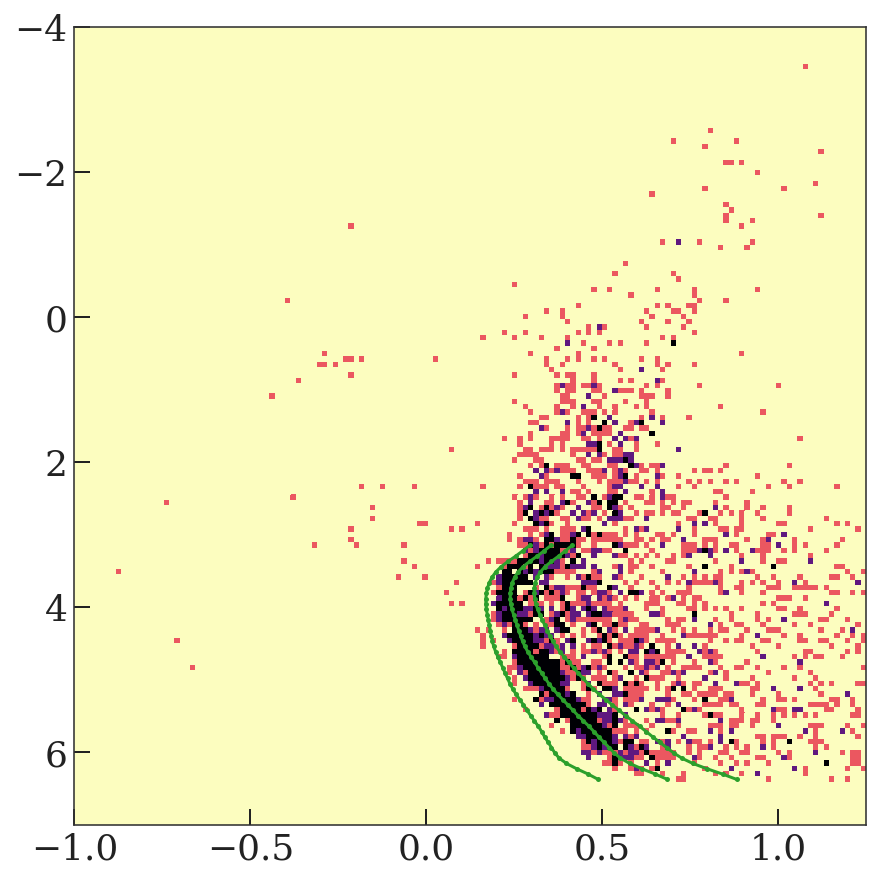

In [16]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

# H /= H.sum(axis=0)
# H /= H.sum(axis=1)[:, None]
H /= H.max()

ax.pcolormesh(
    xe, 
    ye, 
    H.T,
    cmap='magma_r',
    vmin=0, vmax=0.2
)

ax.plot(ms_gi_track, ms_r_track, color='tab:green')
ax.plot(ms_gi_track + 3 * cmd_width_spl(ms_r_track - 3.), ms_r_track, color='tab:green')
ax.plot(ms_gi_track - 3 * cmd_width_spl(ms_r_track - 3.), ms_r_track, color='tab:green')

ax.set_ylim(ax.get_ylim()[::-1])

In [42]:
_x = np.concatenate((
    ms_gi_track - 3 * cmd_width_spl(ms_r_track - 3.),
    ms_gi_track[::-1][1:] + 3 * cmd_width_spl(ms_r_track[::-1][1:] - 3.)
))
_y = np.concatenate((ms_r_track, ms_r_track[::-1][1:]))
cmd_ms_path = mpl.path.Path(np.stack((_x, _y)).T)

girX = np.stack((gi0, Mr0)).T
cmd_ms_mask = cmd_ms_path.contains_points(girX)
cmd_ms_mask.sum()

496357

## BHB and BS

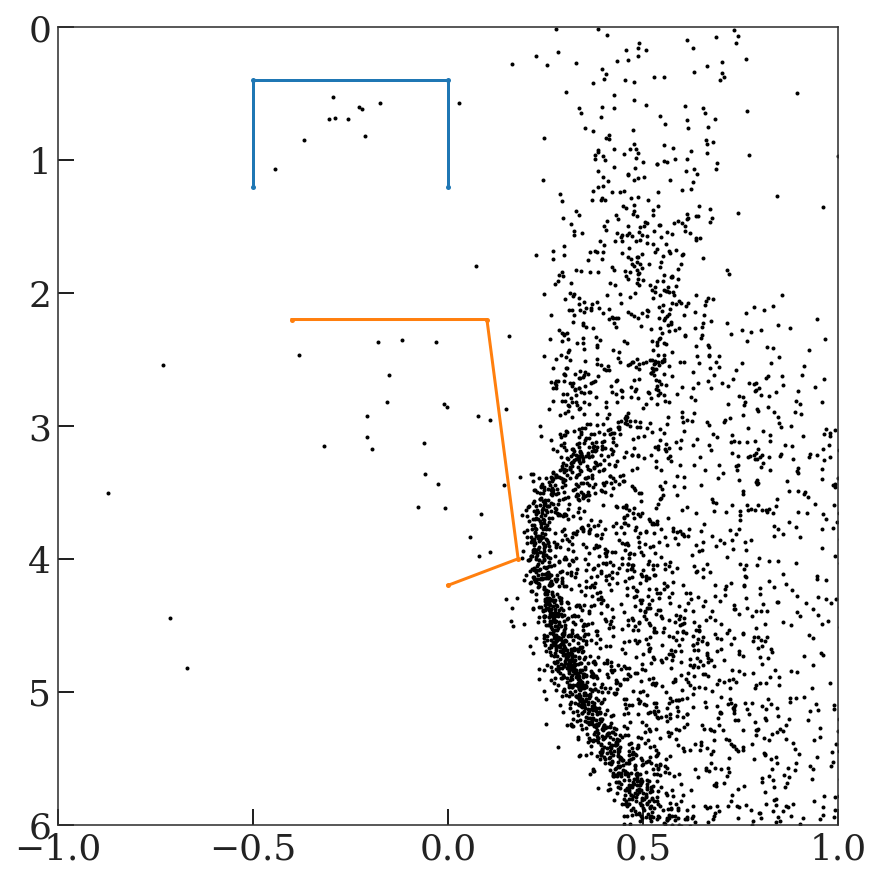

In [44]:
mask = sky_track_mask & rough_pm_mask

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

ax.plot(
    gi0[mask],
    Mr0[mask], 
    marker='o',
    ms=2., 
    ls='none'
)
ax.set_xlim(-1, 1)
ax.set_ylim(6, 0)

bhb_nodes = np.array([
    [-0.5, 1.2],
    [-0.5, 0.4],
    [0, 0.4],
    [0, 1.2]
])
ax.plot(bhb_nodes[:, 0], bhb_nodes[:, 1])

bs_nodes = np.array([
    [-0.4, 2.2],
    [0.1, 2.2],
    [0.18, 4],
    [0.0, 4.2],
#     [-0.4, 2.2],
])
ax.plot(bs_nodes[:, 0], bs_nodes[:, 1])

cmd_bhb_mask = mpl.path.Path(bhb_nodes).contains_points(girX)
cmd_bs_mask = mpl.path.Path(bs_nodes).contains_points(girX)

In [54]:
mask_tbl = at.Table()
mask_tbl['sky_track'] = sky_track_mask
mask_tbl['pm_rough'] = rough_pm_mask
mask_tbl['cmd_ms'] = cmd_ms_mask
mask_tbl['cmd_bs'] = cmd_bs_mask
mask_tbl['cmd_bhb'] = cmd_bhb_mask
mask_tbl.write('../cache/init-masks.fits', overwrite=True)

(-10.0, 5.0)

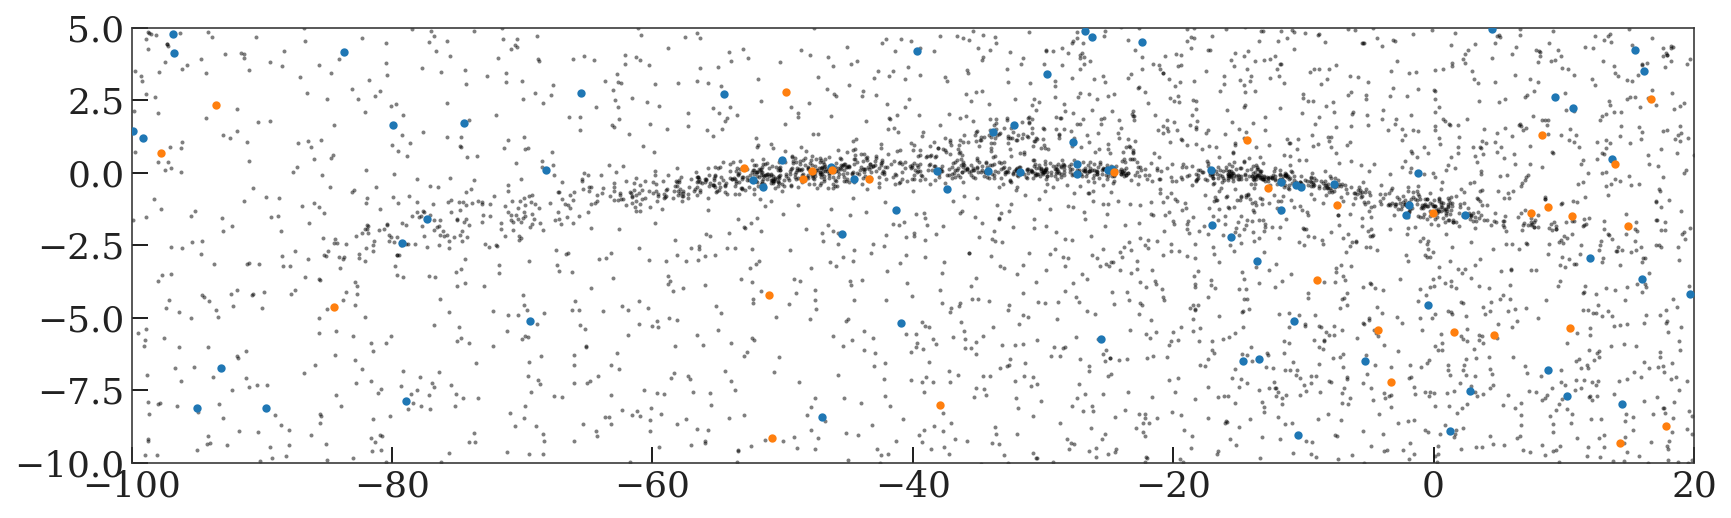

In [52]:
mask = mask_tbl['pm_rough'] & mask_tbl['cmd_ms']

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(
    c_gd1.phi1.degree[mask],
    c_gd1.phi2.degree[mask],
    ls='none',
    marker='o',
    mew=0,
    ms=2,
    alpha=0.5
);

mask = mask_tbl['pm_rough'] & mask_tbl['cmd_bs']
ax.scatter(
    c_gd1.phi1.degree[mask],
    c_gd1.phi2.degree[mask],
    marker='o',
    s=10,
    color='tab:blue',
    zorder=100
);

mask = mask_tbl['pm_rough'] & mask_tbl['cmd_bhb']
ax.scatter(
    c_gd1.phi1.degree[mask],
    c_gd1.phi2.degree[mask],
    marker='o',
    s=10,
    color='tab:orange',
    zorder=100
);

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)